Desafio Redes Neuronales II

In [1]:
#Se importan las librerias necesarias
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.metrics import f1_score
from skopt.space import Real, Integer, Categorical
import warnings
warnings.filterwarnings("ignore")

In [2]:
#1.-Se cargan los DF y se incluyen los encabezados
df_cleveland = pd.read_csv("processed.cleveland.csv")
df_hungarian = pd.read_csv("processed.hungarian.csv")
df_switzerland = pd.read_csv("processed.switzerland.csv")
#Para incluir los encabezados a los df
features_names = ["age", "sex", "cp", "threstbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
df_cleveland.columns = features_names
df_hungarian.columns = features_names
df_switzerland.columns = features_names

In [3]:
# Asignar un valor objetivo (num) de 0 cuando su valor es cero, y 1 en otro caso
df_cleveland['num'] = df_cleveland['num'].apply(lambda x: 0 if x == 0 else 1)
df_hungarian['num'] = df_hungarian['num'].apply(lambda x: 0 if x == 0 else 1)
df_switzerland['num'] = df_switzerland['num'].apply(lambda x: 0 if x == 0 else 1)

In [5]:
# Unir los tres DataFrames en uno solo
df_u = pd.concat([df_cleveland, df_hungarian, df_switzerland])

In [6]:
# Calcular la cantidad de valores ausentes por atributo
missing_values = df_u.isnull().sum()

# Calcular el porcentaje de valores ausentes por atributo
missing_percentage = (missing_values / len(df_u)) * 100

# Filtrar los atributos con un porcentaje de valores ausentes mayor a 25%
atributos_descartar = missing_percentage[missing_percentage > 25].index

# Descartar los atributos con un porcentaje de valores ausentes mayor a 25%
df_u = df_u.drop(atributos_descartar, axis=1)

# Rellenar los valores ausentes con el valor promedio del atributo de acuerdo a la clase
for columna in df_u.columns:
    if df_u[columna].dtype == 'float64':  # Solo para atributos numéricos
        df_u[columna] = df_u.groupby('num')[columna].transform(lambda x: x.fillna(x.mean()).round())

# Mostrar el Data
df_u

,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,70.0,1.0,4.0,115,0,0,1,92,1,0,2,?,7,1
118,70.0,1.0,4.0,140,0,1,0,157,1,2,2,?,7,1
119,72.0,1.0,3.0,160,0,?,2,114,0,1.6,2,2,?,0
120,73.0,0.0,3.0,160,0,0,1,121,0,0,1,?,3,1


In [7]:
# Construir variables dummies para las variables discretas con tres o más categorías
def crear_variables_dummy(df):
    # En la descripción se identifican las variables discretas con tres o mas categorías
    variables_discretas = ["cp", "slope", "restecg", "ca", "thal"]

    # Variables dummy para las columnas con tres o más categorías
    df_con_dummy = pd.get_dummies(df, columns=variables_discretas, dtype=int)
    
    return df_con_dummy

df_u = crear_variables_dummy(df_u)


In [8]:
df_u

,age,sex,threstbps,chol,fbs,thalach,exang,oldpeak,num,cp_1.0,...,ca_2.0,ca_3.0,ca_?,thal_3,thal_3.0,thal_6,thal_6.0,thal_7,thal_7.0,thal_?
0,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,0,...,0,1,0,0,1,0,0,0,0,0
1,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,0,...,1,0,0,0,0,0,0,0,1,0
2,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,0,...,0,0,0,0,1,0,0,0,0,0
4,56.0,1.0,120.0,236.0,0.0,178.0,0.0,0.8,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,70.0,1.0,115,0,0,92,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
118,70.0,1.0,140,0,1,157,1,2,1,0,...,0,0,1,0,0,0,0,1,0,0
119,72.0,1.0,160,0,?,114,0,1.6,0,0,...,0,0,0,0,0,0,0,0,0,1
120,73.0,0.0,160,0,0,121,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0


In [9]:
df_u.replace("?", np.nan, inplace=True)

c. Realiza un análisis descriptivo por variable visualizando histogramas y
gráficos de barra según corresponda. Construye una matriz de correlaciones
con un heatmap, para las variables continuas. Plantea tus observaciones y
conclusiones

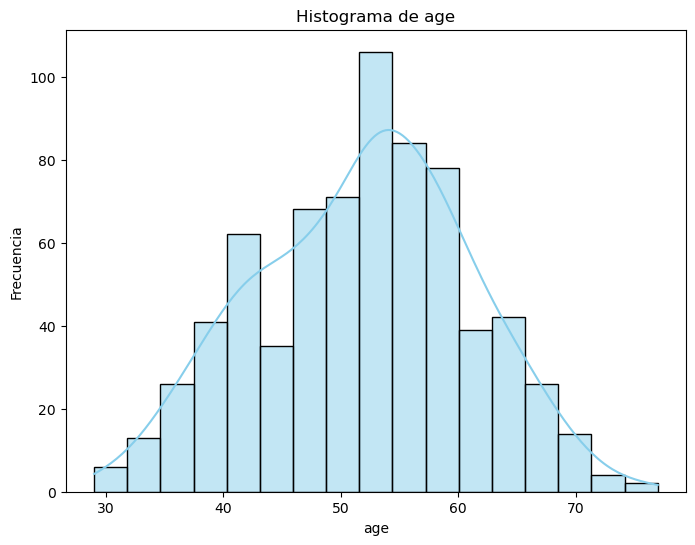

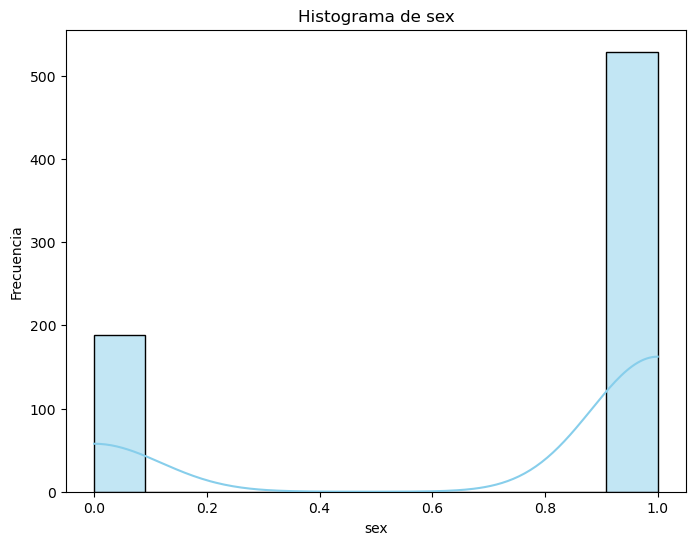

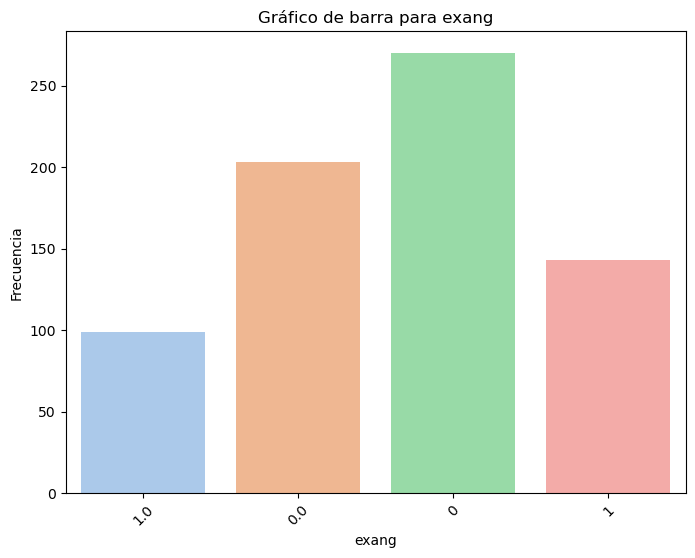

In [10]:
def analisis_descriptivo(df):
    # Histogramas para variables numéricas
    numeric_columns = df.select_dtypes(include = ["float64", "int64"]).columns
    for column in numeric_columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[column], kde=True, color = "skyblue")
        plt.title(f"Histograma de {column}")
        plt.xlabel(column)
        plt.ylabel("Frecuencia")
        plt.show()
    
    # Gráficos de barra para variables categóricas
    categorical_columns = df.select_dtypes(include = ["object"]).columns
    for column in categorical_columns:
        plt.figure(figsize = (8, 6))
        sns.countplot(data = df, x = column, palette = "pastel")
        plt.title(f"Gráfico de barra para {column}")
        plt.xlabel(column)
        plt.ylabel("Frecuencia")
        plt.xticks(rotation = 45)
        plt.show()
df_descriptivo = df_u.drop(columns = ["num","threstbps", "chol", "thalach", "oldpeak", "fbs"])
# Llama a la función pasando tu DataFrame como argumento
analisis_descriptivo(df_descriptivo)

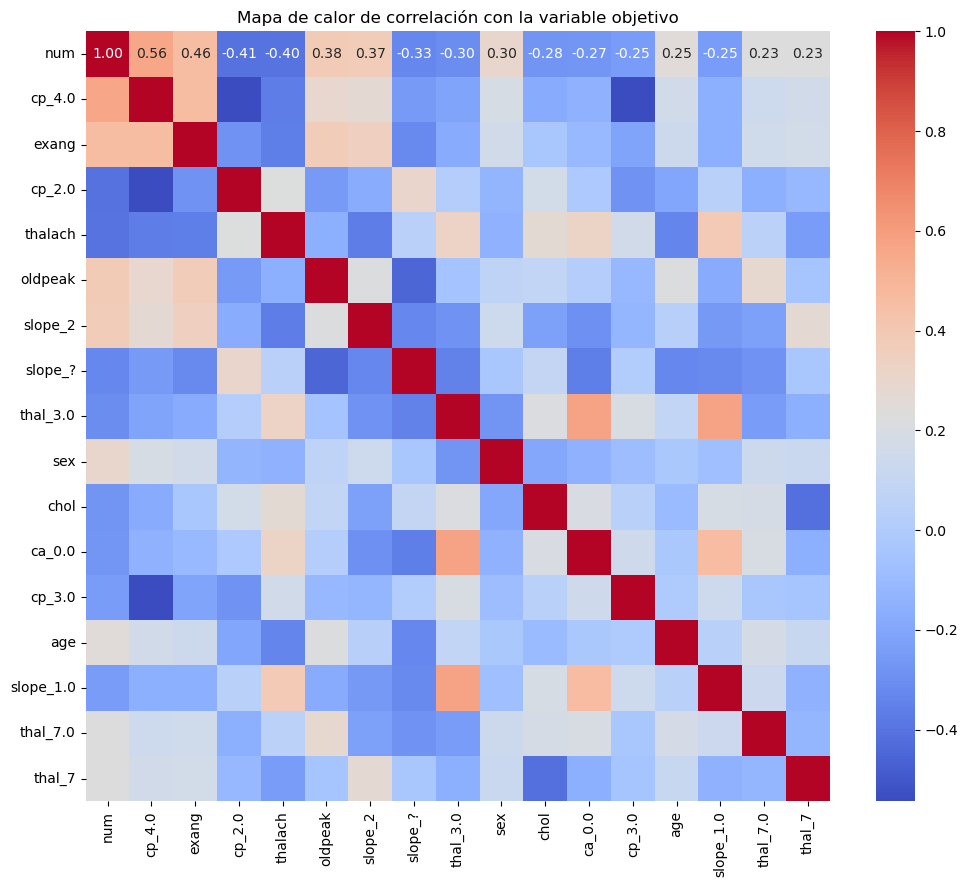

In [13]:

umbral = 0.2
# Calcular la matriz de correlación con la variable objetivo
correlacion = df_u.corr()["num"].abs().sort_values(ascending=False)
variables_seleccionadas = correlacion[correlacion > umbral].index

# Filtrar el DF para incluir solo las variables seleccionadas
df_filtrado = df_u[variables_seleccionadas]

# Calcula la matriz de correlación
correlacion_filtrada = df_filtrado.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlacion_filtrada, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de calor de correlación con la variable objetivo')
plt.show()


In [14]:
correlacion_filtrada

,num,cp_4.0,exang,cp_2.0,thalach,oldpeak,slope_2,slope_?,thal_3.0,sex,chol,ca_0.0,cp_3.0,age,slope_1.0,thal_7.0,thal_7
num,1.000000,0.564922,0.460091,-0.406973,-0.402441,0.379463,0.374636,-0.327595,-0.304965,0.298904,-0.276697,-0.270293,-0.246934,0.246588,-0.245667,0.229614,0.228823
cp_4.0,0.564922,1.000000,0.459984,-0.543571,-0.366807,0.289181,0.270453,-0.251962,-0.208377,0.188414,-0.177756,-0.149948,-0.539176,0.155929,-0.163021,0.139212,0.160153
exang,0.460091,0.459984,1.000000,-0.288349,-0.357177,0.377334,0.350764,-0.316237,-0.176304,0.156654,-0.034969,-0.104707,-0.208050,0.136327,-0.163449,0.154998,0.163897
cp_2.0,-0.406973,-0.543571,-0.288349,1.000000,0.227153,-0.252907,-0.170089,0.306548,0.017417,-0.132125,0.164052,-0.014128,-0.282642,-0.201865,0.037997,-0.153954,-0.112317
thalach,-0.402441,-0.366807,-0.357177,0.227153,1.000000,-0.156932,-0.364550,0.042928,0.325994,-0.147660,0.267230,0.323109,0.159301,-0.333930,0.387864,0.050528,-0.247926
oldpeak,0.379463,0.289181,0.377334,-0.252907,-0.156932,1.000000,0.218439,-0.450932,-0.054964,0.068130,0.084185,0.018580,-0.112014,0.220944,-0.178129,0.288144,-0.044547
slope_2,0.374636,0.270453,0.350764,-0.170089,-0.364550,0.218439,1.000000,-0.329322,-0.284692,0.138524,-0.228443,-0.294725,-0.126108,0.030656,-0.257755,-0.229042,0.270812
slope_?,-0.327595,-0.251962,-0.316237,0.306548,0.042928,-0.450932,-0.329322,1.000000,-0.348499,-0.027933,0.091721,-0.360780,0.006653,-0.327522,-0.315525,-0.280376,-0.026238
thal_3.0,-0.304965,-0.208377,-0.176304,0.017417,0.325994,-0.054964,-0.284692,-0.348499,1.000000,-0.274201,0.214269,0.573368,0.197100,0.086937,0.573510,-0.242379,-0.155072
sex,0.298904,0.188414,0.156654,-0.132125,-0.147660,0.068130,0.138524,-0.027933,-0.274201,1.000000,-0.198161,-0.141109,-0.090741,-0.024094,-0.077714,0.134533,0.119946


Divide la muestra en entrenamiento y test (33%), y con ello:
a. entrena un modelo de ensamble secuencial AdaBoost
b. entrena un modelo de ensamble secuencial Gradient Boosting
c. entrena un modelo de ensamble secuencial XGBoosting

In [15]:
# Eliminar filas con valores nulos
df_u = df_u.dropna()
# Convertir todas las columnas a tipo numérico
df_u = df_u.apply(pd.to_numeric)

def entrenamiento(df):
    X = df_u.drop(columns=["num"]) 
    y = df_u["num"] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Modelo AdaBoost
    aboost_model = AdaBoostClassifier()
    aboost_model.fit(X_train, y_train)
    y_pred = aboost_model.predict(X_test)
    
    print("AdaBoost Classifier:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Modelo Gradient Boosting
    gboost_model = GradientBoostingClassifier()
    gboost_model.fit(X_train, y_train)
    y_pred = gboost_model.predict(X_test)
    
    print("Gradient Boosting Classifier:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Modelo XGBoosting
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    
    print("XGBoost Classifier:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

entrenamiento(df_u)


AdaBoost Classifier:
Accuracy: 0.7512437810945274
              precision    recall  f1-score   support

           0       0.72      0.78      0.74        94
           1       0.79      0.73      0.76       107

    accuracy                           0.75       201
   macro avg       0.75      0.75      0.75       201
weighted avg       0.75      0.75      0.75       201

Gradient Boosting Classifier:
Accuracy: 0.8059701492537313
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        94
           1       0.85      0.77      0.81       107

    accuracy                           0.81       201
   macro avg       0.81      0.81      0.81       201
weighted avg       0.81      0.81      0.81       201

XGBoost Classifier:
Accuracy: 0.8009950248756219
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        94
           1       0.85      0.76      0.80       107

    accuracy            

El Gradient Boosting Classifier y el XGBoost Classifier muestran un rendimiento ligeramente superior al AdaBoost Classifier en términos de precisión, recall y F1-score para ambas clases. Sin embargo, las diferencias son pequeñas y todos los clasificadores muestran un rendimiento bastante similar en general.

In [22]:
#Este codigo quedo ejecutandose por hora y media en un pc i7 9700, 16gb de ram y disco solido, tuve que detenerlo.
# Divide la muestra en entrenamiento y test (33%)
X = df_u.drop(columns=['num'])
y = df_u['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Define la grilla de hiperparámetros
param_grid = {
    'n_estimators': np.linspace(20, 200, 15, dtype=int),
    'learning_rate': np.linspace(0.004, 1.0, 40),
    'subsample': np.linspace(0.1, 1.0, 18)
}

# Inicializa el modelo Gradient Boosting Classifier
gboost_model = GradientBoostingClassifier()

# Inicializa GridSearchCV
grid_search = GridSearchCV(gboost_model, param_grid, scoring='f1', cv=5)

# Realiza la búsqueda de hiperparámetros en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evalúa el modelo con los mejores hiperparámetros en los datos de prueba
best_gboost_model = grid_search.best_estimator_
y_pred = best_gboost_model.predict(X_test)

print("\nDesempeño del modelo con mejores hiperparámetros:")
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

In [33]:
#En sustitucion al e arriba use bayesSearh el cual emitio el resultado casi de inmediato
from skopt.space import Integer, Real
from skopt import BayesSearchCV

param_dist = {
    'n_estimators': Integer(20, 200),
    'learning_rate': Real(0.004, 1.0),
    'subsample': Real(0.1, 1.0),
}


# Inicializa el modelo Gradient Boosting Classifier
gboost_model = GradientBoostingClassifier()

# Inicializa BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=gboost_model,
    search_spaces=param_dist,
    scoring='f1',
    n_iter=50,
    cv=5,
    random_state=42
)

# Realiza la búsqueda de hiperparámetros en los datos de entrenamiento
bayes_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(bayes_search.best_params_)

# Evalúa el modelo con los mejores hiperparámetros en los datos de prueba
best_gboost_model = bayes_search.best_estimator_
y_pred = best_gboost_model.predict(X_test)

print("\nDesempeño del modelo con mejores hiperparámetros:")
print(classification_report(y_test, y_pred))


Mejores hiperparámetros encontrados:
OrderedDict([('learning_rate', 0.4678508392198221), ('n_estimators', 200), ('subsample', 0.8344853745915176)])

Desempeño del modelo con mejores hiperparámetros:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        94
           1       0.85      0.75      0.80       107

    accuracy                           0.80       201
   macro avg       0.80      0.80      0.80       201
weighted avg       0.80      0.80      0.80       201



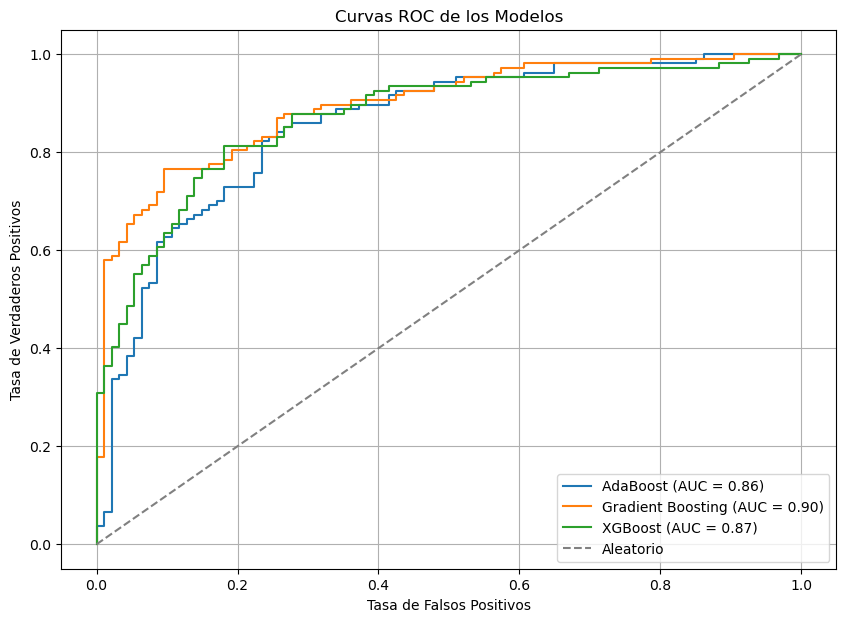

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Inicializa y ajusta el modelo AdaBoost
aboost_model = AdaBoostClassifier()
aboost_model.fit(X_train, y_train)

# Inicializa y ajusta el modelo Gradient Boosting
gboost_model = GradientBoostingClassifier()
gboost_model.fit(X_train, y_train)

# Inicializa y ajusta el modelo XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)


# Calcular las probabilidades de predicción para cada modelo
aboost_probs = aboost_model.predict_proba(X_test)[:, 1]
gboost_probs = gboost_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calcular las tasas de verdaderos positivos y las tasas de falsos positivos para cada modelo
aboost_fpr, aboost_tpr, _ = roc_curve(y_test, aboost_probs)
gboost_fpr, gboost_tpr, _ = roc_curve(y_test, gboost_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# Calcular el área bajo la curva (AUC) para cada modelo
aboost_auc = roc_auc_score(y_test, aboost_probs)
gboost_auc = roc_auc_score(y_test, gboost_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# Graficar las curvas ROC para cada modelo
plt.figure(figsize=(10, 7))
plt.plot(aboost_fpr, aboost_tpr, linestyle='-', label=f'AdaBoost (AUC = {aboost_auc:.2f})')
plt.plot(gboost_fpr, gboost_tpr, linestyle='-', label=f'Gradient Boosting (AUC = {gboost_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC de los Modelos')
plt.legend()
plt.grid(True)
plt.show()


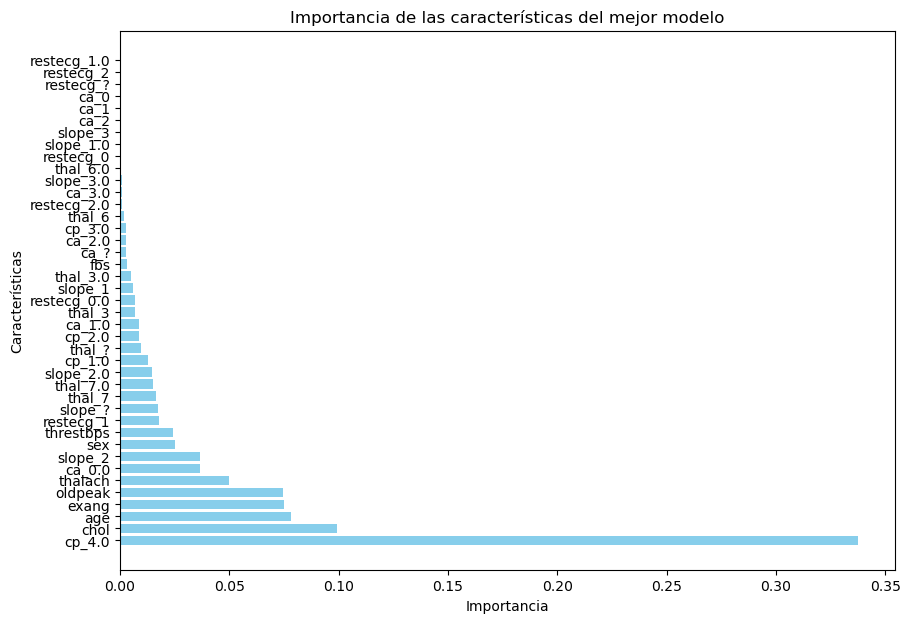

In [39]:
# Obtener el mejor modelo de la búsqueda de hiperparámetros
best_gboost_model = bayes_search.best_estimator_

# Obtener la importancia de las características del mejor modelo
feature_importance = best_model.feature_importances_

# Crear un DataFrame para mostrar las características con su importancia
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Graficar las características por nivel de importancia
plt.figure(figsize=(10, 7))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características del mejor modelo')
plt.show()

La variable "cp_4.0" parece tener una correlación significativa con la variable de salida "num", que representa el diagnóstico de cardiopatía. Esto sugiere que el tipo de dolor torácico clasificado como "asintomático" (valor 4 de la variable "cp") puede ser un factor importante en la predicción del diagnóstico de cardiopatía.
Dado que esta variable tiene una correlación alta y positiva con la variable de salida, podría ser un indicador importante para el modelo de machine learning en la predicción de la enfermedad cardíaca.